Báo cáo đồ án: **PYTHON CHO KHOA HỌC DỮ LIỆU**

**Lớp: 23TTH. Khoa Toán - Tin học.**

**Đề tài: HỆ THỐNG GỢI Ý SẢN PHẨM**

**Giảng viên bộ môn: Ths. Hà Văn Thảo**

**Thành viên nhóm:**

1. Nguyễn Thanh Ngân - 23110192

2. Bùi Hà Bảo Khanh - 23110168

3. Nguyễn Hà Sương Nguyên - 23110196

4. Lê Nguyễn Bảo Thi - 23110208

# **GIỚI THIỆU VẤN ĐỀ**

## **Tổng quan vấn đề**

Trong bối cảnh quá tải thông tin của thương mại điện tử, hệ thống gợi ý đóng vai trò quan trọng giúp cá nhân hóa trải nghiệm và tối ưu doanh thu. Đề tài tập trung xây dựng mô hình dựa trên hành vi khách hàng (`view`, `cart`, `purchase`) và thuộc tính sản phẩm để đưa ra những đề xuất chính xác nhất.

## **Mục tiêu**

Mục tiêu chính của đề tài là xây dựng và so sánh các phương pháp gợi ý khác nhau để tìm ra mô hình tốt nhất cho tập dữ liệu:

### **Content-Based Filtering (Lọc dựa trên nội dung)**

* Xây dựng mô hình gợi ý các sản phẩm tương tự dựa trên đặc điểm của chính sản phẩm đó (như loại hàng, thương hiệu, giá cả).

* Sử dụng các kỹ thuật như **TfidfVectorizer** để xử lý dữ liệu văn bản từ thuộc tính sản phẩm.

### **Collaborative Filtering (Lọc cộng tác)**

* Tận dụng hành vi của cộng đồng người dùng (user-item interaction) để đưa ra gợi ý.

* Áp dụng các thuật toán như Matrix Factorization (SVD) hoặc các thư viện chuyên dụng như `implicit` để xử lý dữ liệu phản hồi ẩn (implicit feedback) từ các sự kiện như xem hoặc thêm vào giỏ hàng.

### **Hybrid Recommender (Hệ thống gợi ý lai)**

Kết hợp ưu điểm của cả hai phương pháp trên nhằm khắc phục các hạn chế như vấn đề "người dùng mới/sản phẩm mới" (Cold Start) và nâng cao độ chính xác tổng thể của hệ thống.

## **CÁC THƯ VIỆN SỬ DỤNG**

In [1]:
%pip install implicit

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import linear_kernel
from functools import lru_cache
import random
from IPython.display import display, HTML
import implicit
import scipy.sparse as sparse
from tqdm.notebook import tqdm

## **Tổng quan về dữ liệu:**

Link Dataset:

https://www.kaggle.com/datasets/mkechinov/ecommerce-events-history-in-electronics-store

In [3]:
df = pd.read_csv('data.csv')

display(df.head())
df.info()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-11-01 14:36:11 UTC,view,4156279,2144415922587172973,electronics.telephone,NaN,12.22,1515915625533221908,krDzDYA6J0
1,2020-10-04 13:48:49 UTC,view,1283611,2144415952391898012,appliances.environment.vacuum,bort,170.00,1515915625469806973,C8YU0DjTP8
2,2020-10-25 06:27:19 UTC,view,3791351,2144415926966026460,computers.components.cpu,amd,204.29,1515915625530210252,GFm0pEaVjK
3,2021-01-12 08:26:56 UTC,view,3957221,2144415922427789416,computers.components.videocards,asus,451.32,1515915625592186998,E57Elq8HVE
4,2020-11-26 12:29:34 UTC,view,227145,2144415921085612102,NaN,NaN,13.00,1515915625544205939,jvqzdCSUUw


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11157 entries, 0 to 11156
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   event_time     11157 non-null  object 
 1   event_type     11157 non-null  object 
 2   product_id     11157 non-null  int64  
 3   category_id    11157 non-null  int64  
 4   category_code  8316 non-null   object 
 5   brand          8447 non-null   object 
 6   price          11157 non-null  float64
 7   user_id        11157 non-null  int64  
 8   user_session   11155 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 784.6+ KB


**Dữ liệu có tất cả 9 cột:**

* **`event_time` (object - Thời gian):** Thời điểm xảy ra sự kiện.

* **`event_type` (object - Phân loại):** Loại tương tác người dùng.

* **`product_id` (int64 - Số nguyên):** Mã định danh duy nhất của sản phẩm.

* **`category_id` (int64 - Số nguyên):** Mã định danh của danh mục sản phẩm.

* **`category_code` (object - Chuỗi):** Tên phân cấp của danh mục.

* **`brand` (object - Chuỗi):** Tên thương hiệu của sản phẩm.

* **`price` (float64 - Số thực):** Giá của sản phẩm tại thời điểm đó.

* **`user_id` (int64 - Số nguyên):** Mã định danh duy nhất của người dùng.

* **`user_session` (object - Chuỗi):** Mã phiên làm việc của người dùng.

**Trong đó:**

* Cột `user_session` có 2 dòng giá trị bị thiếu.

* Cột `brand` có khoảng *2700* dòng giá trị bị thiếu (2710).

* Cột `category_code` có khoảng *2800* dòng giá trị bị thiếu (2841).

# **TIỀN XỬ LÝ & KHÁM PHÁ DỮ LIỆU  (PREPROCESSING & EDA)**

## **TIỀN XỬ LÝ DỮ LIỆU (PREPROCESSING)**

### **LÀM SẠCH DỮ LIỆU (DATA CLEANING)**

#### **Kế hoạch làm sạch và Biến đổi dữ liệu:**
* Chuyển đổi cột `event_time` thành các đối tượng datetime.
* Xử lý các hàng trùng lặp.
* Giải quyết các giá trị bị thiếu bằng cách điền 'Unknown' vào `category_code` và `brand` và xóa các hàng có `user_session` bị thiếu.

**Chuyển đổi kiểu dữ liệu `event_time`** <br>

**Yêu cầu:**

Chuyển đổi cột `event_time` từ kiểu `object` sang kiểu `datetime` để hỗ trợ phân tích thời gian.

**Phương pháp thực hiện:**

Sử dụng `pd.to_datetime()` và sau đó là `df.info()` để chuyển đổi cột `event_time` sang định dạng `datetime` và xác minh thay đổi.

In [4]:
df['event_time'] = pd.to_datetime(df['event_time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11157 entries, 0 to 11156
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   event_time     11157 non-null  datetime64[ns, UTC]
 1   event_type     11157 non-null  object             
 2   product_id     11157 non-null  int64              
 3   category_id    11157 non-null  int64              
 4   category_code  8316 non-null   object             
 5   brand          8447 non-null   object             
 6   price          11157 non-null  float64            
 7   user_id        11157 non-null  int64              
 8   user_session   11155 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(4)
memory usage: 784.6+ KB


**Kiểm tra và Xử lý dữ liệu trùng lặp** <br>

**Yêu cầu:**

Kiểm tra và loại bỏ các hàng dữ liệu bị trùng lặp hoàn toàn để đảm bảo tính duy nhất của dữ liệu, tránh sai lệch trong phân tích và xây dựng mô hình.

**Phương pháp thực hiện:**

Đầu tiên, xác định và đếm số lượng hàng trùng lặp trong DataFrame `df` bằng phương thức `.duplicated()` kết hợp với `.sum()`. Điều này sẽ cho biết số lượng hàng cần loại bỏ.

In [5]:
duplicate_rows = df.duplicated().sum()
print(f"Số lượng dòng trùng lặp tìm được: {duplicate_rows}")

Số lượng dòng trùng lặp tìm được: 0


Vì bước trước đã xác định được 0 hàng trùng lặp, nên việc áp dụng drop_duplicates() sẽ không thay đổi DataFrame, nhưng cần phải thực hiện hành động này một cách rõ ràng theo hướng dẫn.

Sau đó, kiểm tra hình dạng của DataFrame để xác nhận rằng không có hàng nào bị xóa, điều này là bình thường khi không có hàng trùng lặp nào.

In [6]:
initial_shape = df.shape
df.drop_duplicates(inplace=True)

final_shape = df.shape

print(f"Kích thước DataFrame ban đầu: {initial_shape}")
print(f"Kích thước DataFrame sau khi loại bỏ trùng lặp: {final_shape}")

if initial_shape[0] == final_shape[0]:
    print("Không tìm thấy hoặc không có dòng trùng lặp nào bị xóa.")
else:
    print(f"Đã loại bỏ {initial_shape[0] - final_shape[0]} dòng trùng lặp.")

Kích thước DataFrame ban đầu: (11157, 9)
Kích thước DataFrame sau khi loại bỏ trùng lặp: (11157, 9)
Không tìm thấy hoặc không có dòng trùng lặp nào bị xóa.


**Kiểm tra và Xử lý giá trị bị thiếu** <br>



**Đánh giá Mức độ Thiếu Dữ liệu (Assessment)** <br>

**Yêu cầu:**

Kiểm tra và hiển thị số lượng giá trị bị thiếu trong từng cột của DataFrame để xác định mức độ cần làm sạch.

**Phương pháp thực hiện:**

Sử dụng phương thức `.isnull().sum()` trên DataFrame df để đếm và xác định số lượng giá trị bị thiếu trong mỗi cột. Điều này sẽ cung cấp một cái nhìn tổng quan rõ ràng về những cột nào cần được chú ý để làm sạch dữ liệu.

In [7]:
missing_values = df.isnull().sum()
print("Số lượng giá trị thiếu trong mỗi cột:")
print(missing_values)

Số lượng giá trị thiếu trong mỗi cột:
event_time          0
event_type          0
product_id          0
category_id         0
category_code    2841
brand            2710
price               0
user_id             0
user_session        2
dtype: int64


**Xử lý giá trị bị thiếu**

**Yêu cầu:**

Điền giá trị **'Unknown'** vào các cột `category_code` và `brand` có giá trị bị thiếu. Xóa các hàng có giá trị `user_session` bị thiếu do số lượng ít.

**Phương pháp thực hiện:**

 * Điền 'Unknown' vào các cột `category_code` và `brand`.
 * Hiển thị số lượng giá trị còn lại bị thiếu trong các cột này để xác nhận thao tác.

In [8]:
df['category_code'] = df['category_code'].fillna('Unknown')
df['brand'] = df['brand'].fillna('Unknown')

print("Số lượng giá trị thiếu sau khi xử lý:")
print(df[['category_code', 'brand', 'user_session']].isnull().sum())

Số lượng giá trị thiếu sau khi xử lý:
category_code    0
brand            0
user_session     2
dtype: int64


#### **Dữ liệu sau khi xử lý làm sạch**

In [9]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-11-01 14:36:11+00:00,view,4156279,2144415922587172973,electronics.telephone,Unknown,12.22,1515915625533221908,krDzDYA6J0
1,2020-10-04 13:48:49+00:00,view,1283611,2144415952391898012,appliances.environment.vacuum,bort,170.00,1515915625469806973,C8YU0DjTP8
2,2020-10-25 06:27:19+00:00,view,3791351,2144415926966026460,computers.components.cpu,amd,204.29,1515915625530210252,GFm0pEaVjK
3,2021-01-12 08:26:56+00:00,view,3957221,2144415922427789416,computers.components.videocards,asus,451.32,1515915625592186998,E57Elq8HVE
4,2020-11-26 12:29:34+00:00,view,227145,2144415921085612102,Unknown,Unknown,13.00,1515915625544205939,jvqzdCSUUw


### **KHÁM PHÁ VÀ PHÂN TÍCH DỮ LIỆU (Exploratory Data Analysis - EDA)**

**Mục tiêu:** Ở bước này, cần khám phá dữ liệu để xác định phương pháp, cách thức phù hợp cho hệ thống.

#### **Thống kê tổng quan**

In [10]:
n_users = df['user_id'].nunique()
n_products = df['product_id'].nunique()
print(f"-> Tổng số người dùng: {n_users}")
print(f"-> Tổng số sản phẩm: {n_products}")
print(f"-> Tỷ lệ tương tác trung bình: {len(df)/n_users:.2f} hành động/người")

-> Tổng số người dùng: 10640
-> Tổng số sản phẩm: 5844
-> Tỷ lệ tương tác trung bình: 1.05 hành động/người


**Phân phối Các loại tương tác**




**Mục tiêu:** Xem thử người dùng chủ yếu làm gì? Chỉ xem hay mua nhiều?

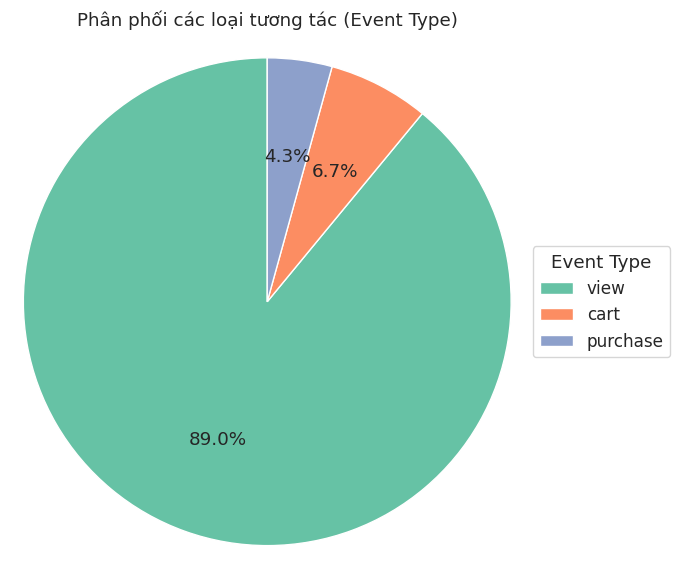

In [11]:
event_counts = df['event_type'].value_counts()
sns.set(style="white", font_scale=1.1)
colors = sns.color_palette("Set2", len(event_counts))
plt.figure(figsize=(7, 6))
plt.pie(event_counts.values, autopct='%1.1f%%',
    startangle=90, colors=colors
)
plt.title('Phân phối các loại tương tác (Event Type)')
plt.legend(labels=event_counts.index, title="Event Type",
    loc="center left", bbox_to_anchor=(1, 0.5)
)
plt.axis('equal')
plt.tight_layout()
plt.show()


**Insight quan trọng:** Hành vi `View` (xem) chiếm tỷ lệ rất cao so với `Cart` (thêm vào giỏ) và `Purchase` (mua hàng). Điều này phản ánh đặc điểm chung của thương mại điện tử, nơi người dùng thường xem nhiều sản phẩm trước khi đưa ra quyết định mua sắm. Số lượng lượt mua hàng khá thấp, cho thấy một tỷ lệ chuyển đổi từ xem sang mua không cao.

**Quyết định cho hệ thống:** Để khuyến nghị hiệu quả, cần gán trọng số khác nhau cho các loại tương tác này. Ví dụ, một lượt mua hàng nên có giá trị cao hơn nhiều so với một lượt xem, để mô hình có thể học được ý định mua hàng thực sự của người dùng. Việc này sẽ giúp mô hình ưu tiên gợi ý những sản phẩm có khả năng dẫn đến giao dịch thực tế.

#### **Phân phối Số sản phẩm duy nhất mà người dùng tương tác**

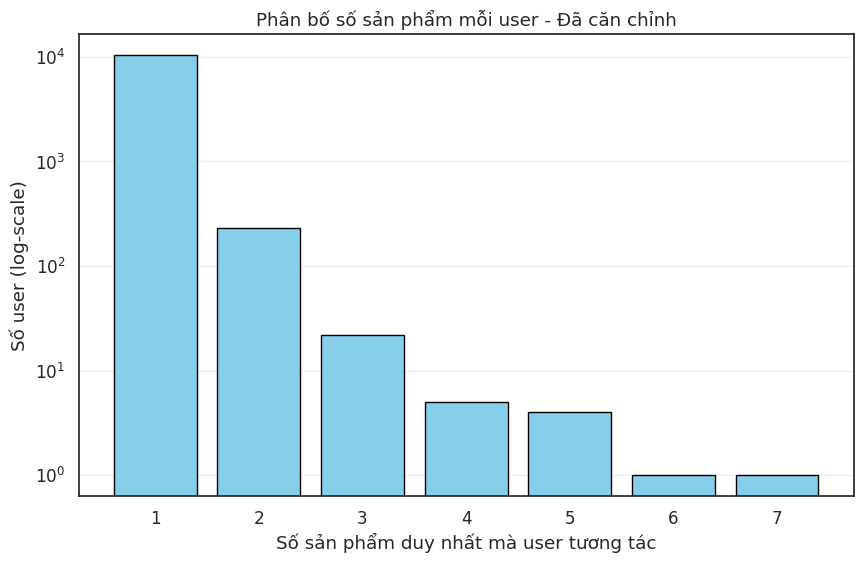

In [12]:
counts = df.groupby("user_id")["product_id"].nunique()
plt.figure(figsize=(10, 6))
bins = np.arange(counts.min(), counts.max() + 2)
plt.hist(counts, bins=bins, align='left', rwidth=0.8, color='skyblue', edgecolor='black')
plt.yscale("log")
plt.xticks(np.arange(counts.min(), counts.max() + 1))
plt.xlabel("Số sản phẩm duy nhất mà user tương tác")
plt.ylabel("Số user (log-scale)")
plt.title("Phân bố số sản phẩm mỗi user - Đã căn chỉnh")
plt.grid(axis='y', alpha=0.3)
plt.show()

Biểu đồ và thống kê cho thấy đa số người dùng chỉ tương tác với rất ít sản phẩm duy nhất (thường là 1 hoặc 2 sản phẩm). Tuy nhiên, vẫn có người dùng tương tác với nhiều sản phẩm hơn (lên đến 7 sản phẩm trong dataset này). Điều này nhấn mạnh sự cần thiết của các chiến lược gợi ý cá nhân hóa:

* **Đối với người dùng có ít tương tác:** Ưu tiên gợi ý các sản phẩm liên quan trực tiếp (dựa trên thuộc tính sản phẩm) hoặc các sản phẩm bán chạy nhất -> Áp dụng phương pháp **Content-Based Filtering**.
* **Đối với người dùng có nhiều tương tác:** Có thể áp dụng các thuật toán **Lọc Cộng Tác** để khuyến khích họ khám phá các sản phẩm đa dạng hơn hoặc các sản phẩm 'ngách' phù hợp -> Áp dụng phương pháp **Collaborative Filtering**.

#### **Top 10 Thương hiệu và Danh mục bán chạy nhất**

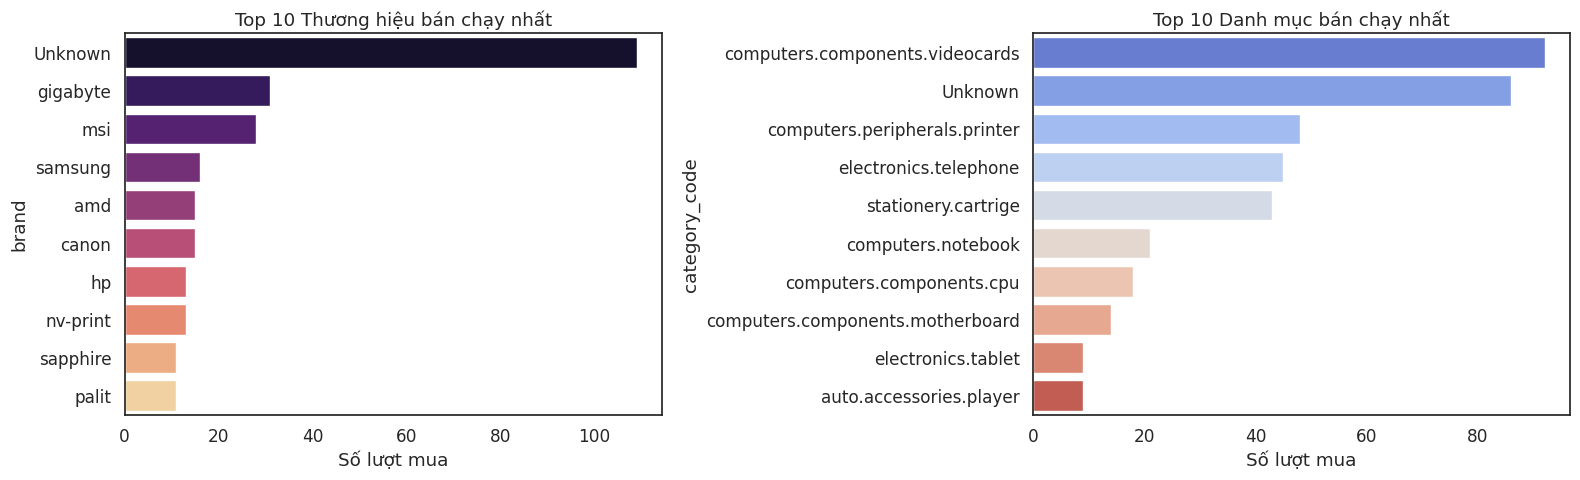

In [13]:
df_purchase = df[df['event_type'] == 'purchase']
top_brands = df_purchase['brand'].value_counts().head(10)
top_categories = df_purchase['category_code'].value_counts().head(10)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.barplot(
    x=top_brands.values,
    y=top_brands.index,
    hue=top_brands.index,
    legend=False,
    ax=axes[0],
    palette='magma'
)
axes[0].set_title('Top 10 Thương hiệu bán chạy nhất')
axes[0].set_xlabel('Số lượt mua')
sns.barplot(
    x=top_categories.values,
    y=top_categories.index,
    hue=top_categories.index,
    legend=False,
    ax=axes[1],
    palette='coolwarm'
)
axes[1].set_title('Top 10 Danh mục bán chạy nhất')
axes[1].set_xlabel('Số lượt mua')
plt.tight_layout()
plt.show()

**Nhận xét**:

* Biểu đồ phản ánh mức độ phổ biến và nhu cầu thực tế của thị trường đối với các sản phẩm của những thương hiệu và danh mục này.

* Hệ thống gợi ý có thể ưu tiên các sản phẩm từ các thương hiệu này để tăng khả năng chuyển đổi, hoặc sử dụng chúng trong các chiến dịch khuyến mãi.

**Quyết định:** Sử dụng TF-IDF trên `category_code` và `brand` là hợp lý để tìm các sản phẩm tương tự về nội dung.



#### **2.1.2.5. Phân phối Giá sản phẩm**

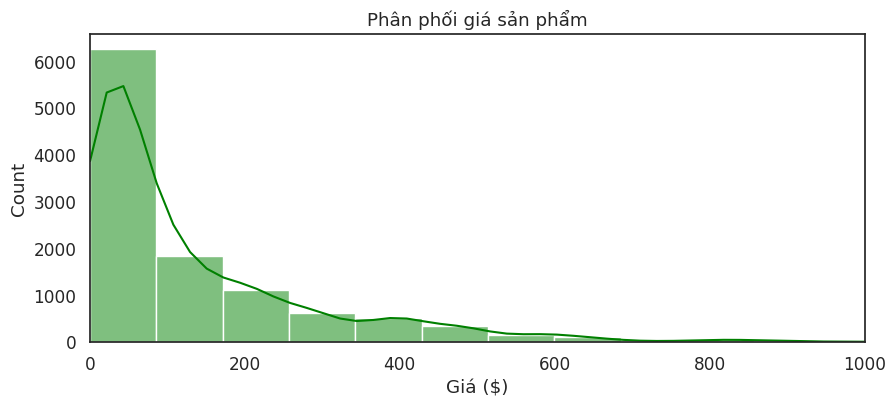

In [14]:
plt.figure(figsize=(10, 4))
sns.histplot(df['price'], bins=50, kde=True, color='green')
plt.title('Phân phối giá sản phẩm')
plt.xlabel('Giá ($)')
plt.xlim(0, 1000)
plt.show()

**Nhận xét:**

Biểu đồ histogram cho thấy:

* Phần lớn sản phẩm có giá thấp, tập trung dưới 200 đơn vị tiền tệ.

* Có một *long tail* với một số ít sản phẩm giá cao.

--> Điều này cho thấy cần mã hóa giá tiền để giảm thiểu ảnh hưởng của các giá trị ngoại lai và đảm bảo mô hình hoạt động hiệu quả trên toàn bộ phân phối giá.

### **MÃ HÓA VÀ CHUẨN HÓA (Encoding & Normalization/Scaling):**

#### **Khái niệm**

##### **Mã hóa (Encoding):**


Mã hóa là quá trình chuyển đổi các thuộc tính dạng phân loại (categorical features) hoặc dạng chữ sang dạng số.

Điều này cần thiết vì hầu hết các thuật toán học máy và phương pháp tính toán độ tương đồng (similarity) đều yêu cầu dữ liệu dạng số.

Trong hệ thống gợi ý, mã hóa được sử dụng cho:

* Thông tin sản phẩm: tên danh mục, thương hiệu, màu sắc, kích thước

* Thông tin người dùng: nhóm tuổi, giới tính

* ID người dùng và ID sản phẩm (dùng cho Matrix Factorization, SVD,…)

##### **Chuẩn hóa (Normalization/Scaling):**
Chuẩn hóa là bước đưa các thuộc tính số về cùng một thang đo (scale).

Nguyên nhân cần chuẩn hóa:

* Các thuộc tính có giá trị lớn (giá tiền) sẽ lấn át các thuộc tính nhỏ (rating).

* Các thuật toán như KNN, clustering, hoặc cosine similarity rất nhạy với độ chênh lệch scale.

* Giúp mô hình hội tụ nhanh hơn, ổn định hơn.

#### **Xử lý dữ liệu**

##### **Xử lý Thời gian (Cyclic Encoding)**

In [15]:
df_final = df.copy()
df_final['day_of_week_num'] = df_final['event_time'].dt.dayofweek + 1
df_final['month_num'] = df_final['event_time'].dt.month
df_final['hour'] = df_final['event_time'].dt.hour

def encode_cyclic_feature(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df

df_final = encode_cyclic_feature(df_final, 'day_of_week_num', 7)
df_final = encode_cyclic_feature(df_final, 'month_num', 12)

##### **Mã hóa Phân loại (OHE) & Chuẩn hóa Số**

In [16]:
cols_to_ohe = ['event_type', 'brand']
df_final = pd.get_dummies(df_final, columns=cols_to_ohe, drop_first=False)

df_final = df_final.rename(columns={
    'event_type_view': 'event_view',
    'event_type_cart': 'event_cart',
    'event_type_purchase': 'event_purchase'
})

In [17]:
scaler = StandardScaler()
df_final['price_scaled'] = scaler.fit_transform(df_final[['price']])

In [18]:
df_final

,event_time,product_id,category_id,category_code,price,user_id,user_session,day_of_week_num,month_num,hour,...,brand_zalman,brand_zebra,brand_zepter,brand_zetton,brand_zhengte,brand_zhongdi,brand_zoweetek,brand_zte,brand_zyxel,price_scaled
0,2020-11-01 14:36:11+00:00,4156279,2144415922587172973,electronics.telephone,12.22,1515915625533221908,krDzDYA6J0,7,11,14,...,False,False,False,False,False,False,False,False,False,-0.627297
1,2020-10-04 13:48:49+00:00,1283611,2144415952391898012,appliances.environment.vacuum,170.00,1515915625469806973,C8YU0DjTP8,7,10,13,...,False,False,False,False,False,False,False,False,False,0.130555
2,2020-10-25 06:27:19+00:00,3791351,2144415926966026460,computers.components.cpu,204.29,1515915625530210252,GFm0pEaVjK,7,10,6,...,False,False,False,False,False,False,False,False,False,0.295257
3,2021-01-12 08:26:56+00:00,3957221,2144415922427789416,computers.components.videocards,451.32,1515915625592186998,E57Elq8HVE,2,1,8,...,False,False,False,False,False,False,False,False,False,1.481795
4,2020-11-26 12:29:34+00:00,227145,2144415921085612102,Unknown,13.00,1515915625544205939,jvqzdCSUUw,4,11,12,...,False,False,False,False,False,False,False,False,False,-0.623550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11152,2021-01-22 09:05:39+00:00,406675,2144415921169498184,Unknown,15.24,1515915625595845461,o6s9FvYBPM,5,1,9,...,False,False,False,False,False,False,False,False,False,-0.612791
11153,2021-02-07 12:26:53+00:00,246841,2144415928811520270,Unknown,29.22,1515915625602456153,EyW8JpZNUt,7,2,12,...,False,False,False,False,False,False,False,False,False,-0.545642
11154,2020-12-19 15:46:44+00:00,4183864,2144415922427789416,computers.components.videocards,587.60,1515915625565385220,uDu86hUZL1,6,12,15,...,False,False,False,False,False,False,False,False,False,2.136377
11155,2021-01-09 11:53:16+00:00,482057,2144415923107266682,computers.peripherals.printer,154.06,1515915625591034266,fntPNqLrjH,6,1,11,...,False,False,False,False,False,False,False,False,False,0.053991


##### **Dọn dẹp cột thừa**

In [19]:
cols_to_drop = ['user_session', 'hour', 'day_of_week_num', 'month_num', 'price', 'category_id']
df_final = df_final.drop(columns=[c for c in cols_to_drop if c in df_final.columns])

print("Dữ liệu sau khi xử lý:")
df_final.info()
df_final.head()

Dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11157 entries, 0 to 11156
Columns: 560 entries, event_time to price_scaled
dtypes: bool(551), datetime64[ns, UTC](1), float64(5), int64(2), object(1)
memory usage: 6.6+ MB


,event_time,product_id,category_code,user_id,day_of_week_num_sin,day_of_week_num_cos,month_num_sin,month_num_cos,event_cart,event_purchase,...,brand_zalman,brand_zebra,brand_zepter,brand_zetton,brand_zhengte,brand_zhongdi,brand_zoweetek,brand_zte,brand_zyxel,price_scaled
0,2020-11-01 14:36:11+00:00,4156279,electronics.telephone,1515915625533221908,-2.449294e-16,1.000000,-0.500000,0.866025,False,False,...,False,False,False,False,False,False,False,False,False,-0.627297
1,2020-10-04 13:48:49+00:00,1283611,appliances.environment.vacuum,1515915625469806973,-2.449294e-16,1.000000,-0.866025,0.500000,False,False,...,False,False,False,False,False,False,False,False,False,0.130555
2,2020-10-25 06:27:19+00:00,3791351,computers.components.cpu,1515915625530210252,-2.449294e-16,1.000000,-0.866025,0.500000,False,False,...,False,False,False,False,False,False,False,False,False,0.295257
3,2021-01-12 08:26:56+00:00,3957221,computers.components.videocards,1515915625592186998,9.749279e-01,-0.222521,0.500000,0.866025,False,False,...,False,False,False,False,False,False,False,False,False,1.481795
4,2020-11-26 12:29:34+00:00,227145,Unknown,1515915625544205939,-4.338837e-01,-0.900969,-0.500000,0.866025,False,False,...,False,False,False,False,False,False,False,False,False,-0.623550


# **TÁCH DATA**

## **Phương pháp Phân chia Dữ liệu (Methodology)**

Thay vì sử dụng phương pháp chia ngẫu nhiên (Random Split) thông thường, dự án áp dụng phương pháp *Chia theo thời gian* (Time-based Split).

Quy trình:

* Toàn bộ dữ liệu tương tác được sắp xếp tăng dần theo trục thời gian (`event_time`).

* Điểm cắt (Split point) được xác định tại mốc 80% tổng số lượng bản ghi.

* Tập Huấn luyện (Train Set): Bao gồm 80% dữ liệu tương tác đầu tiên (Dữ liệu quá khứ).

* Tập Kiểm thử (Test Set): Bao gồm 20% dữ liệu tương tác sau cùng (Dữ liệu tương lai).

## **Lý do lựa chọn**

Việc lựa chọn *Time-based Split* thay vì *Random Split* dựa trên các cơ sở sau:

* **Mô phỏng thực tế (Simulation of Reality):** Trong các bài toán gợi ý, mục tiêu là sử dụng hành vi trong quá khứ để dự đoán sở thích trong tương lai. Việc chia ngẫu nhiên sẽ làm mất đi tính thứ tự thời gian này.

* **Tránh rò rỉ dữ liệu (Preventing Data Leakage):** Nếu chia ngẫu nhiên, mô hình có thể "nhìn thấy" hành vi của người dùng trong tương lai (ví dụ: tháng 12) để dự đoán hành vi trong quá khứ (ví dụ: tháng 11). Điều này dẫn đến kết quả kiểm thử cao giả tạo (Over-optimistic) nhưng thất bại khi triển khai thực tế.

* **Thách thức "Cold Start":** Phương pháp này tự động tạo ra kịch bản kiểm thử khó hơn nhưng thực tế hơn, đó là phải dự đoán cho những người dùng hoặc sản phẩm mới chỉ xuất hiện trong tương lai (tập Test) mà chưa từng có trong quá khứ (tập Train).

## **Kỹ thuật Xây dựng Biến mục tiêu (Target Variable Engineering)**

Do dữ liệu đầu vào là dạng Phản hồi ẩn (Implicit Feedback - chỉ có hành vi xem, thêm giỏ, mua chứ không có chấm điểm sao), chúng tôi đã thực hiện kỹ thuật **Gán trọng số (Weighting)** để lượng hóa mức độ quan tâm của người dùng:

* **Hệ số quan tâm:**

  * View (Xem): 1 điểm

  * Cart (Thêm vào giỏ): 2 điểm

  * Purchase (Mua): 3 điểm

In [20]:
VIEW_WEIGHT = 1
CART_WEIGHT = 2
PURCHASE_WEIGHT = 3

df_final['interaction_score'] = (
    df_final['event_view'] * VIEW_WEIGHT +
    df_final['event_cart'] * CART_WEIGHT +
    df_final['event_purchase'] * PURCHASE_WEIGHT
)

## **Xử lý Tách Data**

**Vấn đề**: Nếu một người dùng view sản phẩm 100 lần (do spam hoặc F5 liên tục), điểm số sẽ là 100. Điều này không có nghĩa là họ thích sản phẩm gấp 100 lần người view 1 lần.

**Giải pháp**: Sử dụng hàm Logarit để giảm thiểu tác động của các giá trị ngoại lai (outliers) và tạo ra "lợi ích cận biên giảm dần" (diminishing returns)

$$Score_{u,i} = w_{view} \times \log(1 + n_{view}) + w_{cart} \times \log(1 + n_{cart}) + w_{purchase} \times \log(1 + n_{purchase})$$

### **Sắp xếp dữ liệu theo thời gian thực tế**

In [21]:
data = df_final.sort_values('event_time').copy()

### **Cải thiện cách tính điểm (Log Normalization)**

In [22]:
data['interaction_score'] = (
    VIEW_WEIGHT * np.log1p(df_final['event_view']) +
    CART_WEIGHT * np.log1p(df_final['event_cart']) +
    PURCHASE_WEIGHT * np.log1p(df_final['event_purchase'])
    ).astype(np.float64)

### **Chia Train/Test theo thời gian (80% cũ nhất để học -> 20% mới nhất để thi)**

In [23]:
train_size = int(len(data) * 0.8)

train_data = data.iloc[:train_size].copy()
test_data = data.iloc[train_size:].copy()

# **XÂY DỰNG MÔ HÌNH (MODELING)**

## **MÔ HÌNH CƠ SỞ (Baseline): Trending**

### **Bài toán Gợi ý Sản phẩm (Ranking)**

**Mục tiêu:** Nếu chỉ gợi ý đồ "Hot Trend", tỷ lệ trúng là bao nhiêu?

**Xây dựng Baseline cho bài toán Xếp hạng (Ranking Baseline):**

Bên cạnh việc dự đoán điểm số, hệ thống gợi ý thực tế cần đưa ra danh sách Top N sản phẩm. Chúng tôi xây dựng mô hình Popularity (Trending) làm đối trọng:

* **Chiến lược:** Gợi ý danh sách Top 10 sản phẩm có tổng điểm tương tác (*interaction_score*) cao nhất trong tập huấn luyện cho TẤT CẢ người dùng, không phân biệt sở thích cá nhân.

* **Cách tiếp cận:** Mô hình không học theo từng người dùng mà chỉ dựa trên mức độ phổ biến toàn cục của sản phẩm. Do đó, danh sách gợi ý từ baseline là cố định và giống nhau cho mọi người dùng.

* **Vai trò:** Chuẩn tham chiếu (*reference model*), giúp đánh giá liệu các mô hình cá nhân hóa (ALS, Content-Based, Hybrid) có thực sự cải thiện chất lượng gợi ý so với chiến lược đơn giản dựa trên độ phổ biến hay không.

In [24]:
print("\n>>> XÂY DỰNG MÔ HÌNH POPULARITY (TRENDING)...")

popular_products = train_data.groupby('product_id')['interaction_score'].sum().sort_values(ascending=False)
top_10_trending = popular_products.head(10).index.tolist()

print(f"🔥 Top 10 sản phẩm Trending: {top_10_trending}")


>>> XÂY DỰNG MÔ HÌNH POPULARITY (TRENDING)...
🔥 Top 10 sản phẩm Trending: [1821813, 3791351, 3829355, 4099645, 1785245, 809948, 3642540, 4154414, 4027952, 3791509]


## **MÔ HÌNH LỌC CỘNG TÁC**

### **Chuyển đổi Cấu trúc dữ liệu (Data Transformation):**

Để áp dụng thuật toán Lọc cộng tác (Collaborative Filtering), dữ liệu cần được chuyển đổi từ dạng bảng dọc (Long format - mỗi dòng là một tương tác) sang dạng Ma trận thưa (Sparse Matrix):

* **Hàng (Rows):** Đại diện cho người dùng (`User ID`).

* **Cột (Columns):** Đại diện cho sản phẩm (`Product ID`).

* **Giá trị (Values):** Là tổng điểm tương tác (`interaction_score`).

### **Kỹ thuật xử lý:**

* **Gộp điểm (Aggregation):** Sử dụng hàm `sum` để cộng dồn điểm số nếu một người dùng có nhiều tương tác với cùng một sản phẩm trong quá khứ (Ví dụ: xem 2 lần + thêm vào giỏ 1 lần). Điều này giúp phản ánh chính xác tổng mức độ quan tâm.

* **Xử lý giá trị khuyết (Missing Values):** Các ô trống (người dùng chưa bao giờ tương tác với sản phẩm) được điền giá trị `0`.

#### **Tạo ma trận User-Item từ tập train**

In [25]:
user_item_matrix = train_data.pivot_table(
    index='user_id',
    columns='product_id',
    values='interaction_score',
    aggfunc='sum'
).fillna(0)

#### **Kiểm tra kích thước**

In [26]:
n_users = user_item_matrix.shape[0]
n_items = user_item_matrix.shape[1]

print(f"Kích thước ma trận huấn luyện: {n_users} Users x {n_items} Products")

Kích thước ma trận huấn luyện: 8534 Users x 5111 Products


#### **Tính độ thưa (Sparsity)**

In [27]:
total_elements = n_users * n_items
non_zero_elements = np.count_nonzero(user_item_matrix.values)
sparsity = 1 - (non_zero_elements / total_elements)

#### **Kết quả**

In [28]:
print("-" * 30)
print(f"Tổng số ô trong ma trận: {total_elements}")
print(f"Số ô có tương tác thật:   {non_zero_elements}")
print(f"-> Độ thưa (Sparsity):   {sparsity:.4%}")
print("-" * 30)

print("\n5 dòng đầu tiên của ma trận User-Item:")
print(user_item_matrix.head())

------------------------------
Tổng số ô trong ma trận: 43617274
Số ô có tương tác thật:   8769
-> Độ thưa (Sparsity):   99.9799%
------------------------------

5 dòng đầu tiên của ma trận User-Item:
product_id           102      105      817      2260     2349     2674     \
user_id                                                                     
1515915625353234047      0.0      0.0      0.0      0.0      0.0      0.0   
1515915625353294441      0.0      0.0      0.0      0.0      0.0      0.0   
1515915625353411684      0.0      0.0      0.0      0.0      0.0      0.0   
1515915625353482553      0.0      0.0      0.0      0.0      0.0      0.0   
1515915625353487799      0.0      0.0      0.0      0.0      0.0      0.0   

product_id           2712     2717     2855     3017     ...  4183856  \
user_id                                                  ...            
1515915625353234047      0.0      0.0      0.0      0.0  ...      0.0   
1515915625353294441      0.0      0.0   

#### **Phân tích Độ thưa (Sparsity Analysis):**

* Kết quả cho thấy ma trận có độ thưa rất cao (> 99.9%). Điều này có nghĩa là một người dùng trung bình chỉ tương tác với một phần rất nhỏ trong tổng số hàng ngàn sản phẩm có trên sàn.

### **SƠ LƯỢT**

**a. Lý do lựa chọn ALS** 

**Tính chất dữ liệu:** Dữ liệu thu thập được là Implicit Feedback (Phản hồi ẩn) như hành vi View, Add-to-cart, Purchase. Người dùng không trực tiếp chấm điểm (Rating 1-5 sao) cho sản phẩm.

**Sự phù hợp:** Các thuật toán như SVD truyền thống hoạt động tốt trên dữ liệu Explicit (Rating), nhưng kém hiệu quả trên Implicit. ALS được thiết kế chuyên biệt để xử lý dữ liệu ẩn bằng cách đưa vào khái niệm "Độ tin cậy" (Confidence).

*Ví dụ:* Nếu user xem sản phẩm A 10 lần, hệ thống sẽ có "độ tin cậy" cao rằng user thích A, hơn là user chỉ xem sản phẩm B 1 lần.

**b. Cơ chế hoạt động** 

Mô hình sẽ phân rã Ma trận Tương tác (User-Item Matrix) khổng lồ thành hai ma trận thấp chiều hơn:

* **User Factors:** Vector đặc trưng ẩn đại diện cho sở thích của người dùng.

* **Item Factors:** Vector đặc trưng ẩn đại diện cho thuộc tính của sản phẩm.

* **Dự đoán:** Điểm số (Score) sự quan tâm của User $u$ với Item $i$ là tích vô hướng của hai vector này.

**c. Quy trình thực hiện**

* **Mapping ID:** Chuyển đổi User ID và Product ID (dạng chuỗi/số lớn) sang dạng chỉ mục (Index 0, 1, 2...) để tối ưu hóa bộ nhớ.

* **Tạo Ma trận thưa (Sparse Matrix):** Tạo ma trận kích thước $(N_{users} \times M_{items})$ chứa trọng số tương tác.

* **Huấn luyện:** Sử dụng thư viện implicit để học các vector ẩn.

**d. Các tham số chính (Hyperparameters)**

* `factors`: Số chiều ẩn (Latent features). Số càng lớn mô hình càng phức tạp.

* `regularization`: Hệ số điều quy để tránh Overfitting (học vẹt).

* `alpha`: Trọng số giúp tăng độ mạnh của các tương tác dương (Positive interactions).

### **Huấn luyện Mô hình ALS**

#### **Tạo Mapping**

In [29]:
user_unique = train_data['user_id'].unique()
item_unique = train_data['product_id'].unique()

user_to_idx = {v: k for k, v in enumerate(user_unique)}
idx_to_item = {k: v for k, v in enumerate(item_unique)}
item_to_idx = {v: k for k, v in enumerate(item_unique)}

#### **Tạo Ma trận Tương tác**

In [30]:
train_data['user_idx'] = train_data['user_id'].map(user_to_idx)
train_data['product_idx'] = train_data['product_id'].map(item_to_idx)

row = train_data['user_idx'].values
col = train_data['product_idx'].values
data = train_data['interaction_score'].values

matrix_user_item = sparse.csr_matrix((data, (row, col)), shape=(len(user_unique), len(item_unique)))

#### **Cấu hình và Train ALS**

In [31]:
model_als = implicit.als.AlternatingLeastSquares(factors=64, regularization=0.05, iterations=20, random_state=42)

alpha_val = 40
data_conf = (matrix_user_item * alpha_val).astype('double')

model_als.fit(data_conf)

print(f"Huấn luyện hoàn tất! Kích thước ma trận: {matrix_user_item.shape}")

/home/python25/.local/lib/python3.12/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 32 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/20 [00:00<?, ?it/s]

Huấn luyện hoàn tất! Kích thước ma trận: (8534, 5111)


### **Hàm Gợi ý Sản phẩm**

In [32]:
def get_als_recommendations(user_id, top_n=10):
    if user_id not in user_to_idx:
        return []

    user_idx = user_to_idx[user_id]

    ids, scores = model_als.recommend(
        user_idx,
        matrix_user_item[user_idx],
        N=top_n,
        filter_already_liked_items=True
    )

    recommended_products = [idx_to_item[i] for i in ids]

    return recommended_products

## **MÔ HÌNH LỌC NỘI DUNG**

### **Huấn luyện Mô hình Lọc nội dung**

#### **Chuẩn bị Dữ liệu Sản phẩm**

In [33]:
df_products = df[['product_id', 'brand', 'category_code']].copy()

df_products['product_id'] = df_products['product_id'].astype('int64')
df_products['brand'] = df_products['brand'].astype(str).replace(['nan', 'None'], 'unknown').str.lower()
df_products['category_code'] = df_products['category_code'].astype(str).replace(['nan', 'None'], 'unknown').str.lower()

df_products['info_score'] = (df_products['brand'] != 'unknown').astype(int) + \
                            (df_products['category_code'] != 'unknown').astype(int)

products_unique = df_products.sort_values('info_score', ascending=False) \
                        .drop_duplicates('product_id') \
                        .reset_index(drop=True)

products_unique['text_features'] = (
    products_unique['brand'].str.replace('unknown', '', case=False) + " " +
    products_unique['category_code'].str.replace('unknown', '', case=False).str.replace('.', ' ')
).str.strip()

print(f"Số lượng sản phẩm duy nhất sau khi làm sạch: {len(products_unique)}")

Số lượng sản phẩm duy nhất sau khi làm sạch: 5844


#### **Vector hóa & Tính Độ tương đồng**

In [34]:
tfidf = TfidfVectorizer(stop_words=None, min_df=1)
tfidf_matrix = tfidf.fit_transform(products_unique['text_features'])

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

indices = pd.Series(products_unique.index, index=products_unique['product_id']).drop_duplicates()

#### **Tính Độ phổ biến Brand**

In [35]:
train_items = train_data[['product_id']].copy()

train_items_with_info = train_items.merge(
    products_unique[['product_id', 'brand']],
    on='product_id',
    how='left'
)

brand_popularity = train_items_with_info['brand'].value_counts().to_dict()
products_unique['brand_pop'] = products_unique['brand'].map(brand_popularity).fillna(0)
products_unique['is_known_brand'] = products_unique['brand'].apply(lambda x: 0 if str(x).lower() == 'unknown' else 1)

print(f"✅ Đã train xong! Số lượng sản phẩm duy nhất: {len(products_unique)}")
print(f"Kích thước ma trận tương đồng: {cosine_sim.shape}")

✅ Đã train xong! Số lượng sản phẩm duy nhất: 5844
Kích thước ma trận tương đồng: (5844, 5844)


### **Hàm Gợi ý Sản phẩm**

In [36]:
def get_content_recommendations(product_id, top_n=10):
    try:
        product_id = int(product_id)
    except:
        return pd.DataFrame()
    # -- Trường hợp 1: Sản phẩm có trong dữ liệu đã học --
    if product_id in indices:
        idx = indices[product_id]

        sim_scores = list(enumerate(cosine_sim[idx]))

        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:31]

        product_indices = [i[0] for i in sim_scores]
        scores = [i[1] for i in sim_scores]

        result = products_unique.iloc[product_indices].copy()
        result['similarity_score'] = scores
        result['note'] = 'Content Match'

        result = result.sort_values(
            by=['similarity_score', 'is_known_brand', 'brand_pop'],
            ascending=[False, False, False]
        )

        return result.head(top_n)[['product_id', 'brand', 'category_code', 'similarity_score', 'note']]

    # -- Trường hợp 2: FALLBACK (Dự phòng) --
    try:
        cat = products_unique[products_unique['product_id'] == product_id]['category_code'].iloc[0]
        candidates = products_unique[
            (products_unique['category_code'] == cat) &
            (products_unique['product_id'] != product_id)
        ]
        if candidates.empty: return pd.DataFrame()

        candidates = candidates.sort_values(
            by=['is_known_brand', 'brand_pop'],
            ascending=[False, False]
        )

        result = candidates.head(top_n)[['product_id', 'brand', 'category_code']].copy()
        result['similarity_score'] = 0.5
        result['note'] = 'Category Fallback'

        return result

    except:
        return pd.DataFrame()

## **MÔ HÌNH LAI HYBRID**

### **Phân loại người dùng (User Segmentation)**
Để cá nhân hóa trải nghiệm gợi ý, việc phân loại người dùng thành các nhóm (ví dụ: người dùng 'thân thiết' và người dùng 'vãng lai' hay 'mới') là rất quan trọng. Điều này giúp áp dụng các chiến lược gợi ý phù hợp hơn cho từng đối tượng.

In [37]:
user_counts_train = train_data['user_id'].value_counts()
loyalty_threshold = 2

loyal_ids = user_counts_train[user_counts_train >= loyalty_threshold].index
casual_ids = user_counts_train[user_counts_train < loyalty_threshold].index

loyal_users_df = train_data[train_data['user_id'].isin(loyal_ids)][['user_id']].drop_duplicates()
casual_users_df = train_data[train_data['user_id'].isin(casual_ids)][['user_id']].drop_duplicates()

In [38]:
print("\nDataFrame người dùng Thân thiết:")
display(loyal_users_df.head())
print(f"Tổng số người dùng Thân thiết: {len(loyal_users_df)}")

print("\nDataFrame người dùng Vãng lai:")
display(casual_users_df.head())
print(f"Tổng số người dùng Vãng lai: {len(casual_users_df)}")


DataFrame người dùng Thân thiết:


,user_id
10096,1515915625519064114
7921,1515915625520449790
2318,1515915625520175322
11014,1515915625517748115
8211,1515915625512176731


Tổng số người dùng Thân thiết: 322

DataFrame người dùng Vãng lai:


,user_id
5879,1515915625519389712
3005,1515915625519388006
5684,1515915625508483528
6695,1515915625519392459
2733,1515915625519401790


Tổng số người dùng Vãng lai: 8212


### **Xây dựng hệ thống HYBRID**

Để tận dụng ưu điểm của cả hai mô hình *Lọc cộng tác (ALS)* và *Lọc nội dung (Content-based)*, đồng thời giải quyết triệt để vấn đề *Khởi động lạnh (Cold Start)*, nhóm đề xuất sử dụng chiến lược *Lai ghép Chuyển đổi (Switching Hybrid)* kết hợp với *Lai ghép Trọng số (Weighted Hybrid)*.

Hệ thống hoạt động theo cơ chế **Thác nước" (Waterfall Logic)**, phân luồng người dùng thành 3 nhóm đối tượng để áp dụng thuật toán tối ưu nhất

**a. Sơ đồ Quy trình Xử lý**

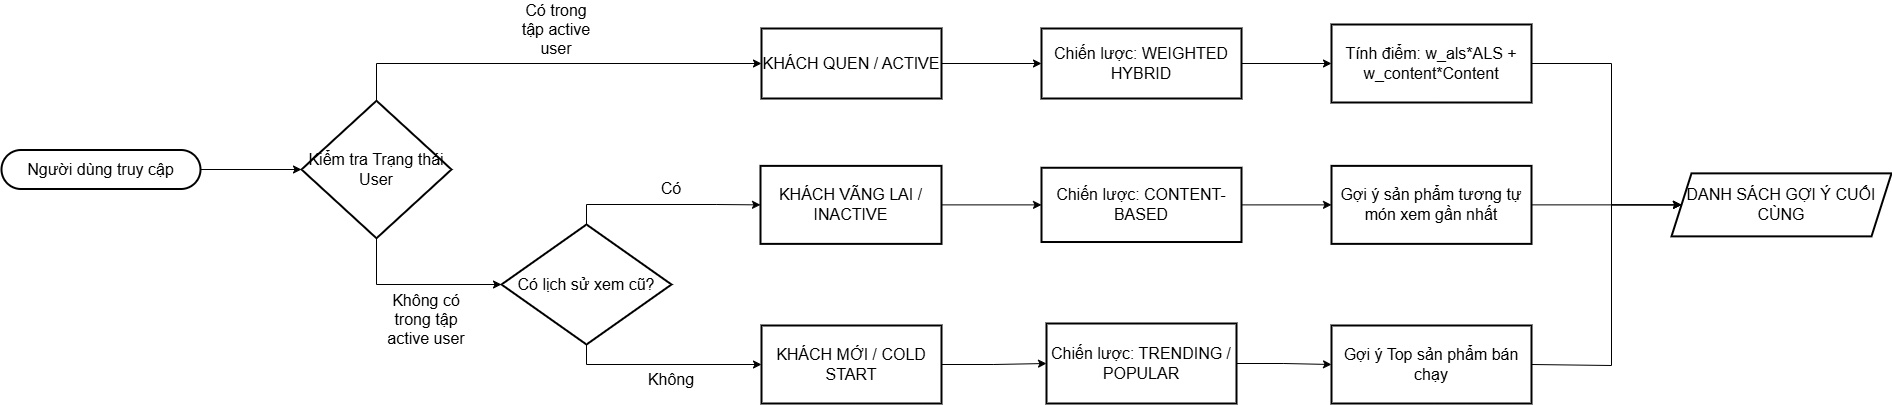

**b. Chi tiết Quy trình Xử lý**

**Trường hợp 1:** Khách hàng thân thiết (Active Users)

* **Định nghĩa:** Người dùng có lịch sử tương tác đủ lớn và tồn tại trong tập huấn luyện của mô hình ALS.

* **Phương pháp:** Sử dụng Weighted Hybrid. Hệ thống tính toán điểm số từ cả hai mô hình và cộng gộp theo trọng số:$$Score_{final} = (w_{ALS} \times Score_{ALS}) + (w_{Content} \times Score_{Content})$$

* **Trong đó:** Điểm số được chuẩn hóa về đoạn $[0, 1]$ trước khi cộng. Nhóm đề xuất trọng số $w_{ALS} = 0.6$ (ưu tiên hành vi) và $w_{Content} = 0.4$ (bổ trợ ngữ cảnh).

**Trường hợp 2:** Khách vãng lai (Inactive Users)

* **Định nghĩa:** Người dùng có tương tác nhưng quá ít (dưới ngưỡng lọc), không có vector đặc trưng trong mô hình ALS.

* **Phương pháp:** Sử dụng Content-based Filtering. Hệ thống truy xuất sản phẩm người dùng xem gần nhất (Last Interaction) và gợi ý các sản phẩm có nội dung/đặc tính tương đồng.

**Trường hợp 3:** Khách hàng mới (Cold Start Users)

* **Định nghĩa:** Người dùng lần đầu truy cập, chưa có bất kỳ dữ liệu lịch sử nào.

* **Phương pháp:** Sử dụng Popularity-based (Trending). Hệ thống gợi ý danh sách các sản phẩm đang bán chạy nhất hoặc được xem nhiều nhất trên toàn sàn để tối ưu hóa khả năng thu hút.

**c. Ưu điểm của Chiến lược:**

* Khắc phục điểm yếu của ALS khi gặp người dùng mới (không tính được vector).

* Khắc phục điểm yếu của Content-based (thiếu tính khám phá) bằng cách ưu tiên ALS cho khách quen.

* Đảm bảo luôn có gợi ý (100% Coverage) cho mọi người dùng truy cập hệ thống.

In [39]:
def normalize_scores(scores):
    scores = np.array(scores)

    if scores.size == 0:
        return np.array([])

    max_score = scores.max()
    if max_score == 0:
        return scores

    return scores / max_score

def get_hybrid_recommendations(user_id, current_viewed_product_id=None, top_n=10, w_als=0.6, w_content=0.4):
    if user_id in casual_users_df:
        w_als = 0.0
        w_content = 1.0

    hybrid_scores = {}

    if w_als > 0 and user_id in user_to_idx:
        try:
            user_idx = user_to_idx[user_id]
            user_vector = matrix_user_item[user_idx]

            ids, scores = model_als.recommend(
                user_idx,
                user_vector,
                N=50,
                filter_already_liked_items=True
            )

            norm_scores = normalize_scores(scores)
            for i, score in zip(ids, norm_scores):
                pid = str(idx_to_item[i])
                hybrid_scores[pid] = hybrid_scores.get(pid, 0) + (score * w_als)
        except Exception as e:
            print(f"⚠️ Lỗi ALS: {e}")

    if w_content > 0:
        target_pid = current_viewed_product_id

        if target_pid is None:
            try:
                history = df[df['user_id'] == user_id].sort_values('event_time', ascending=False)
                if not history.empty:
                    target_pid = str(history.iloc[0]['product_id'])
            except:
                pass

        if target_pid is not None:
            try:
                content_df = get_content_recommendations(target_pid, top_n=50)
                if not content_df.empty:
                    for _, row in content_df.iterrows():
                        pid = str(row['product_id'])
                        score = row['similarity_score']

                        weight = w_content if (w_als > 0 and user_id in user_to_idx) else 1.0

                        hybrid_scores[pid] = hybrid_scores.get(pid, 0) + (score * weight)
            except Exception as e:
                pass

    valid_scores = {k: v for k, v in hybrid_scores.items() if v > 0}

    sorted_scores = sorted(valid_scores.items(), key=lambda x: x[1], reverse=True)
    final_recs = [item[0] for item in sorted_scores[:top_n]]

    if user_id not in user_to_idx:
        top_n_trending = popular_products.head(top_n).index.tolist()
        return [str(x) for x in top_n_trending]

    return final_recs

## **DEMO**

**Hàm hỗ trợ hiển thị bảng**

Hàm `display_recommendations_as_table` dùng để hiển thị kết quả gợi ý sản phẩm dưới dạng bảng, giữ nguyên thứ tự gợi ý của thuật toán và bổ sung nhãn thuật toán để tiện so sánh.

* Nhận kết quả gợi ý (danh sách `product_id`)
* Lấy thông tin sản phẩm tương ứng từ `products_unique`
* Hiển thị thành bảng (`product_id`, `brand`, `category_id`, tên thuật toán)

In [40]:
def display_recommendations_as_table(rec_result, title_note = ''):
    if not rec_result:
        print(f"⚠️ Không có gợi ý nào ({title_note}).")
        return

    if isinstance(rec_result, list):
        rec_ids = [str(x) for x in rec_result]

        products_unique['product_id'] = products_unique['product_id'].astype(str)
        df_show = products_unique[products_unique['product_id'].isin(rec_ids)].copy()
        df_show['product_id'] = pd.Categorical(df_show['product_id'], categories=rec_ids, ordered=True)
        df_show = df_show.sort_values('product_id')
        df_show['algorithm_note'] = title_note

        cols = ['product_id', 'brand', 'category_code', 'algorithm_note']
        valid_cols = [c for c in cols if c in df_show.columns]
        display(df_show[valid_cols].head(len(rec_result)))

**Hàm in chân dung khách hàng**

Hàm `print_user_persona` được sử dụng để phân tích nhanh hồ sơ người dùng dựa trên lịch sử tương tác, giúp phân biệt người dùng mới (cold-start) và người dùng có dữ liệu (warm user), đồng thời giải thích hành vi gợi ý của hệ thống. Đây là một bước quan trọng để kiểm chứng: *""Tại sao hệ thống lại gợi ý món đồ này cho khách hàng đó?*

* Kiểm tra: User này là ai, có dữ liệu không?
* Thống kê: Họ đã làm gì? Thích thương hiệu nào? Hay mua nhóm hàng nào?
* Hiển thị: In ra để đối chiếu với danh sách gợi ý.

In [41]:
def print_user_persona(user_id):
    print(f"\n👤 --- KHÁCH HÀNG: {user_id} ---")

    if user_id not in user_to_idx:
        print("   [Trạng thái] Khách Mới tinh.")
        return

    try:
        history = df[df['user_id'] == user_id]
        if history.empty:
            history = df[df['user_id'].astype(str) == str(user_id)]

        if history.empty:
            print("   [Trạng thái] Có ID trong hệ thống nhưng không tìm thấy log lịch sử.")
        else:
            top_brands = history['brand'].value_counts().head(3).index.tolist()
            top_cats = history['category_code'].value_counts().head(3).index.tolist()
            print(f"   [Lịch sử] Đã tương tác {len(history)} lần.")
            print(f"   [Sở thích] Brands: {top_brands} | Cats: {top_cats}")
    except Exception as e:
        print(f"   [Lỗi tra cứu] {e}")

**Kịch bản Demo**

Kịch bản 1: Khách hàng thân thiết

In [42]:
print("\n" + "="*60)
print("🎬 KỊCH BẢN 1: Khách hàng thân thiết")
print("="*60)

active_user = loyal_users_df['user_id'].sample().values[0]

print_user_persona(active_user)

print("\n👉 Gợi ý (Chiến lược: HYBRID):")
recs_home = get_hybrid_recommendations(
    user_id=active_user,
    current_viewed_product_id=None,
    top_n=5
)
display_recommendations_as_table(recs_home, title_note="Hybrid")


🎬 KỊCH BẢN 1: Khách hàng thân thiết

👤 --- KHÁCH HÀNG: 1515915625533040665 ---
   [Lịch sử] Đã tương tác 2 lần.
   [Sở thích] Brands: ['aerocool', 'amd'] | Cats: ['computers.components.power_supply', 'computers.components.cpu']

👉 Gợi ý (Chiến lược: HYBRID):


,product_id,brand,category_code,algorithm_note
3064,1821813,unknown,computers.components.videocards,Hybrid
180,2810442,aerocool,computers.components.power_supply,Hybrid
723,1549665,aerocool,computers.components.power_supply,Hybrid
803,130780,aerocool,computers.components.power_supply,Hybrid
1154,1531291,aerocool,computers.components.power_supply,Hybrid


Kịch bản 2: Khách hàng vãng lai đã có lịch sử tương tác

In [43]:
print("\n" + "="*60)
print("🎬 KỊCH BẢN 2: Khách hàng vãng lai đã có lịch sử tương tác")
print("="*60)

casual_user = casual_users_df['user_id'].sample().values[0]

print_user_persona(casual_user)

print("\n👉 Gợi ý (Chiến lược: Content-based):")
recs_home = get_hybrid_recommendations(
    user_id=casual_user,
    current_viewed_product_id=None,
    top_n=5
)
display_recommendations_as_table(recs_home, title_note="Content-based")


🎬 KỊCH BẢN 2: Khách hàng vãng lai đã có lịch sử tương tác

👤 --- KHÁCH HÀNG: 1515915625540105869 ---
   [Lịch sử] Đã tương tác 1 lần.
   [Sở thích] Brands: ['logitech'] | Cats: ['computers.peripherals.joystick']

👉 Gợi ý (Chiến lược: Content-based):


,product_id,brand,category_code,algorithm_note
10,1301733,ark,electronics.telephone,Content-based
875,1452884,canon,computers.peripherals.printer,Content-based
114,3642540,hp,stationery.cartrige,Content-based
109,4099645,gigabyte,computers.components.videocards,Content-based
5262,287525,unknown,unknown,Content-based


Kịch bản 3: Khách hàng mới chưa có lịch sử tương tác (cold start)

In [44]:
print("\n" + "="*60)
print("🎬 KỊCH BẢN 3: Khách Mới Tinh (COLD START)")
print("="*60)

new_user = '999999999999'

print_user_persona(new_user)

print("\n👉 Gợi ý (Chiến lược: Trending):")
recs_home = get_hybrid_recommendations(
    user_id=new_user,
    current_viewed_product_id=None,
    top_n=5
)
display_recommendations_as_table(recs_home, title_note="Trending")


🎬 KỊCH BẢN 3: Khách Mới Tinh (COLD START)

👤 --- KHÁCH HÀNG: 999999999999 ---
   [Trạng thái] Khách Mới tinh.

👉 Gợi ý (Chiến lược: Trending):


,product_id,brand,category_code,algorithm_note
3064,1821813,unknown,computers.components.videocards,Trending
3,3791351,amd,computers.components.cpu,Trending
3160,3829355,unknown,electronics.telephone,Trending
109,4099645,gigabyte,computers.components.videocards,Trending
50,1785245,canon,stationery.cartrige,Trending


# **ĐÁNH GIÁ MÔ HÌNH**

**Các chỉ số đo lường (Metrics)**

Hệ thống sử dụng Top-K Recommendation và được đánh giá qua 2 chỉ số chính:

* Precision (Độ chính xác): Trong $K$ sản phẩm được gợi ý, có bao nhiêu sản phẩm người dùng thực sự đã tương tác trong tập Test.

  Công thức: $\frac{\text{Số sản phẩm gợi ý đúng}}{K}$

* Recall (Độ phủ): Trong tất cả các sản phẩm người dùng đã tương tác trong tập Test, hệ thống tìm lại được bao nhiêu phần trăm.

  Công thức: $\frac{\text{Số sản phẩm gợi ý đúng}}{\text{Tổng số sản phẩm user đã tương tác thực tế}}$

In [45]:
print("="*60)
print("📊 ĐÁNH GIÁ CHI TIẾT: ALS vs CONTENT vs HYBRID vs TRENDING")
print("="*60)

def evaluate_all_methods(test_df, top_n=10):
    test_user_products = test_data.groupby('user_id')['product_id'].apply(list).to_dict()

    metrics = {
        "ALS (Collaborative)": {"hits": 0, "total_recs": 0},
        "Content-Based":       {"hits": 0, "total_recs": 0},
        "Hybrid (Kết hợp)":    {"hits": 0, "total_recs": 0},
        "Trending (Baseline)": {"hits": 0, "total_recs": 0}
    }

    total_relevant = 0
    evaluated_users = 0

    trending_recs = popular_products.head(top_n).index.tolist()
    trending_set = set(str(x) for x in trending_recs)

    for user_id, true_item_ids in tqdm(test_user_products.items(), desc="Đang so sánh các thuật toán..."):

        if user_id in user_to_idx:

            true_set = set(str(x) for x in true_item_ids)
            total_relevant += len(true_set)
            evaluated_users += 1

            metrics["Trending (Baseline)"]["hits"] += len(trending_set & true_set)
            metrics["Trending (Baseline)"]["total_recs"] += top_n

            try:
                recs_als = get_hybrid_recommendations(user_id, None, top_n, w_als=1.0, w_content=0.0)
                rec_set_als = set(str(x) for x in recs_als)
                metrics["ALS (Collaborative)"]["hits"] += len(rec_set_als & true_set)
                metrics["ALS (Collaborative)"]["total_recs"] += len(rec_set_als)
            except: pass

            try:
                recs_content = get_hybrid_recommendations(user_id, None, top_n, w_als=0.0, w_content=1.0)
                rec_set_content = set(str(x) for x in recs_content)
                metrics["Content-Based"]["hits"] += len(rec_set_content & true_set)
                metrics["Content-Based"]["total_recs"] += len(rec_set_content)
            except: pass

            try:
                recs_hybrid = get_hybrid_recommendations(user_id, None, top_n, w_als=0.6, w_content=0.4)
                rec_set_hybrid = set(str(x) for x in recs_hybrid)
                metrics["Hybrid (Kết hợp)"]["hits"] += len(rec_set_hybrid & true_set)
                metrics["Hybrid (Kết hợp)"]["total_recs"] += len(rec_set_hybrid)
            except: pass

    results_df = []

    for method_name, data in metrics.items():
        hits = data["hits"]
        total_recs = data["total_recs"]

        precision = hits / total_recs if total_recs > 0 else 0
        recall = hits / total_relevant if total_relevant > 0 else 0

        results_df.append({
            "Phương pháp": method_name,
            "Precision": precision,
            "Recall": recall,
            "Recall (%)": f"{recall*100:.2f}%"
        })

    return pd.DataFrame(results_df), evaluated_users

df_results, num_users = evaluate_all_methods(test_data, top_n=10)

📊 ĐÁNH GIÁ CHI TIẾT: ALS vs CONTENT vs HYBRID vs TRENDING


Đang so sánh các thuật toán...:   0%|          | 0/2127 [00:00<?, ?it/s]

**Kết quả & So sánh**

In [46]:
print(f"\n📋 KẾT QUẢ ĐÁNH GIÁ TRÊN {num_users} KHÁCH HÀNG (ACTIVE):")
display(df_results.sort_values("Recall", ascending=False))

best_model = df_results.sort_values("Recall", ascending=False).iloc[0]


📋 KẾT QUẢ ĐÁNH GIÁ TRÊN 21 KHÁCH HÀNG (ACTIVE):


,Phương pháp,Precision,Recall,Recall (%)
2,Hybrid (Kết hợp),0.047619,0.333333,33.33%
1,Content-Based,0.040816,0.266667,26.67%
0,ALS (Collaborative),0.019048,0.133333,13.33%
3,Trending (Baseline),0.014286,0.100000,10.00%


Kết quả thực nghiệm cho thấy mô hình Hybrid hoạt động hiệu quả nhất với Recall đạt ~33%, giúp khoanh vùng tốt nhu cầu tiềm ẩn của khách hàng bất chấp dữ liệu thưa. Mặc dù Precision chỉ đạt ~4.7%, đây là mức chấp nhận được đối với bài toán Top-N Recommendation nhằm ưu tiên tính đa dạng và khả năng khám phá sản phẩm mới cho người dùng thay vì chỉ tập trung vào độ chính xác tuyệt đối.

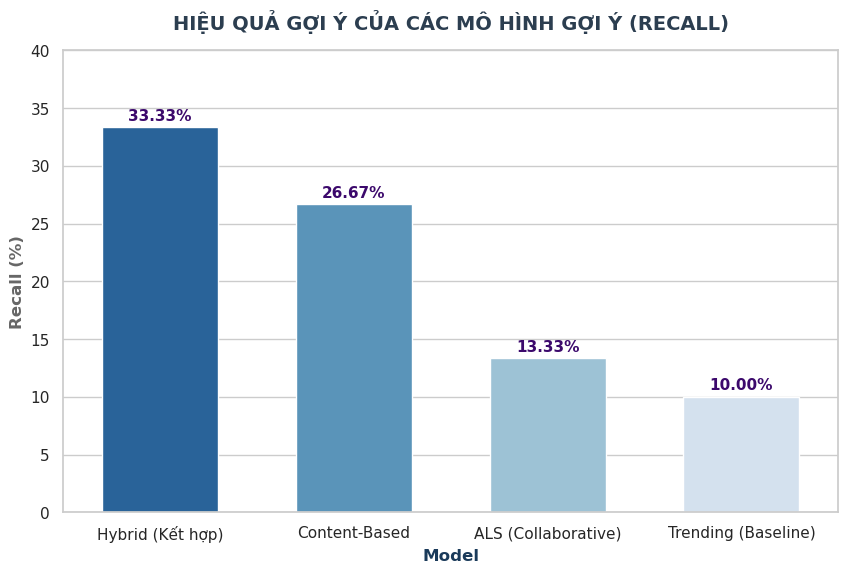

In [47]:
plot_df = df_results.copy()
plot_df['Recall_VeBieuDo'] = plot_df['Recall'] * 100
plot_df = plot_df.sort_values("Recall_VeBieuDo", ascending=False)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

main_color = '#3C096C'

ax = sns.barplot(x='Phương pháp', y='Recall_VeBieuDo', hue='Phương pháp', data=plot_df, palette='Blues_r', width=0.6, legend=False)
ax.set_xlabel('Model', fontsize=12, fontweight='bold', color='#1A3A5A')
ax.set_ylabel('Recall (%)', fontsize=12, fontweight='bold', color='#666666')

for container in ax.containers:
  ax.bar_label(container, fmt='%.2f%%', padding=3, fontsize=11, fontweight='bold', color=main_color)

plt.title('HIỆU QUẢ GỢI Ý CỦA CÁC MÔ HÌNH GỢI Ý (RECALL)', fontsize=14, fontweight='bold', pad=15, color='#2C3E50')
plt.ylim(0, 40)
plt.show()

# **KẾT LUẬN**

## **Kết quả đạt được**
* **Xây dựng mô hình đa dạng:** Triển khai thành công 3 phương pháp Content-Based (dựa trên đặc trưng sản phẩm), Collaborative Filtering (dựa trên hành vi người dùng) và Hybrid Recommender (hệ thống lai).

* **Xử lý dữ liệu hiệu quả:** Sử dụng kỹ thuật **TfidfVectorizer** để trích xuất đặc trưng sản phẩm và thư viện `implicit` để xử lý các hành vi phản hồi ẩn như `view`, `cart`, `purchase`.

* **Cá nhân hóa trải nghiệm:** Hệ thống đã đưa ra được các gợi ý sát với sở thích cá nhân, giúp giải quyết bài toán quá tải thông tin và hỗ trợ người dùng tìm kiếm sản phẩm nhanh chóng.

## **Hạn chế & Hướng phát triển**
* **Hạn chế:** Mô hình Hybrid vẫn cần tối ưu hơn về tốc độ xử lý khi tập dữ liệu mở rộng và độ chính xác có thể bị ảnh hưởng bởi các hành vi người dùng ngẫu nhiên (nhiễu dữ liệu).

* **Hướng phát triển:** Tích hợp các thuật toán học sâu (Deep Learning) như Neural Collaborative Filtering và mở rộng thêm các thuộc tính như hình ảnh hoặc đánh giá văn bản để tăng cường độ chính xác cho hệ thống.

# **TÀI LIỆU THAM KHẢO**

*  Các file bài giảng môn Python cho Khoa học dữ liệu của ThS. Hà Văn Thảo
* Mô hình lai Hybrid: https://medium.com/analytics-vidhya/7-types-of-hybrid-recommendation-system-3e4f78266ad8
* Các mô hình gợi ý cơ bản: https://viblo.asia/p/tong-quan-ve-recommender-system-recommender-system-co-ban-phan-1-924lJGBb5PM
* Các tài liệu liên quan khác